In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/seg/apture

/content/drive/MyDrive/seg/apture


In [3]:
%cd /content/drive/MyDrive/seg/kaggle_3m

/content/drive/MyDrive/seg/kaggle_3m


In [4]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

root_dir = '/content/drive/MyDrive/seg/apture'
image_size = (128, 128)

images = []
masks = []

for patient_folder in os.listdir(root_dir):
    patient_path = os.path.join(root_dir, patient_folder)

    if not os.path.isdir(patient_path):
        continue

    images_dir = os.path.join(patient_path, "images")
    masks_dir = os.path.join(patient_path, "masks")

    if not os.path.exists(images_dir) or not os.path.exists(masks_dir):
        continue

    for filename in tqdm(os.listdir(images_dir), desc=f"Processing {patient_folder}"):
        if filename.lower().endswith('.png') and '_mask' not in filename.lower():
            image_path = os.path.join(images_dir, filename)

            base_name, _ = os.path.splitext(filename)
            mask_name = base_name + '_mask.png'
            mask_path = os.path.join(masks_dir, mask_name)

            if not os.path.exists(mask_path):
                print(f" No mask for {filename}")
                continue

            try:
                img = Image.open(image_path).convert('L')
                mask = Image.open(mask_path).convert('L')

                img = img.resize(image_size)
                mask = mask.resize(image_size)

                img_array = np.array(img) / 255.0
                mask_array = np.array(mask) / 255.0

                images.append(img_array.reshape(128, 128, 1))
                masks.append(mask_array.reshape(128, 128, 1))
            except Exception as e:
                print(f"Error in {filename}: {e}")

images = np.array(images)
masks = np.array(masks)

print("✅ Images shape:", images.shape)
print("✅ Masks shape:", masks.shape)

Processing patient2: 100%|██████████| 27/27 [00:24<00:00,  1.12it/s]

✅ Images shape: (196, 128, 128, 1)
✅ Masks shape: (196, 128, 128, 1)


In [9]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [10]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/seg/kaggle_3m/unet_model.h5", compile=False)

model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

Train shape: (156, 128, 128, 1) (156, 128, 128, 1)
Val shape: (40, 128, 128, 1) (40, 128, 128, 1)


In [12]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=20,
    verbose=1
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 656ms/step - dice_coef: 0.2760 - loss: 0.7245 - val_dice_coef: 0.0714 - val_loss: 0.9286
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - dice_coef: 0.5953 - loss: 0.4051 - val_dice_coef: 0.0812 - val_loss: 0.9188
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - dice_coef: 0.7156 - loss: 0.2846 - val_dice_coef: 0.1809 - val_loss: 0.8191
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - dice_coef: 0.6803 - loss: 0.3197 - val_dice_coef: 0.6127 - val_loss: 0.3873
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - dice_coef: 0.7596 - loss: 0.2404 - val_dice_coef: 0.6636 - val_loss: 0.3364
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - dice_coef: 0.7972 - loss: 0.2028 - val_dice_coef: 0.5657 - val_loss: 0.4343
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - dice_coef: 0.8024 - loss: 0.1976 - val_dice_coef: 0.7018 - val_loss: 0.2982
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - dice_coef: 0.8322 - loss: 0.1679 - 

In [44]:
model.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 846ms/step - dice_coef: 0.6860 - loss: 0.3226


[0.3197411000728607, 0.6932198405265808]

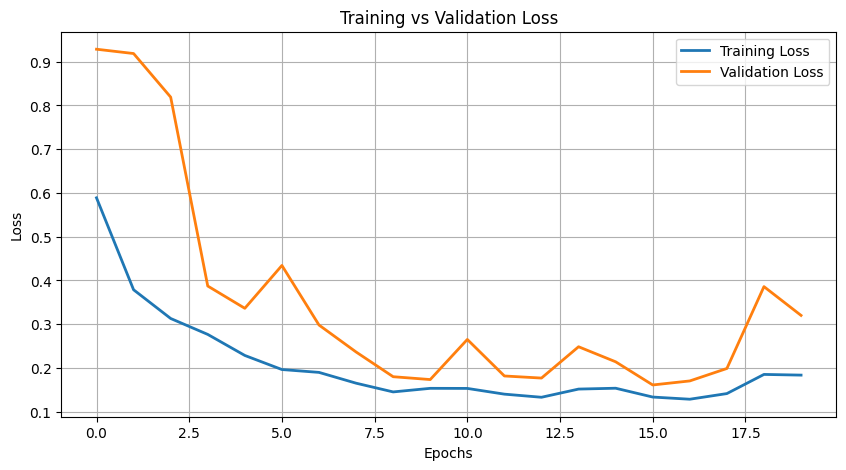

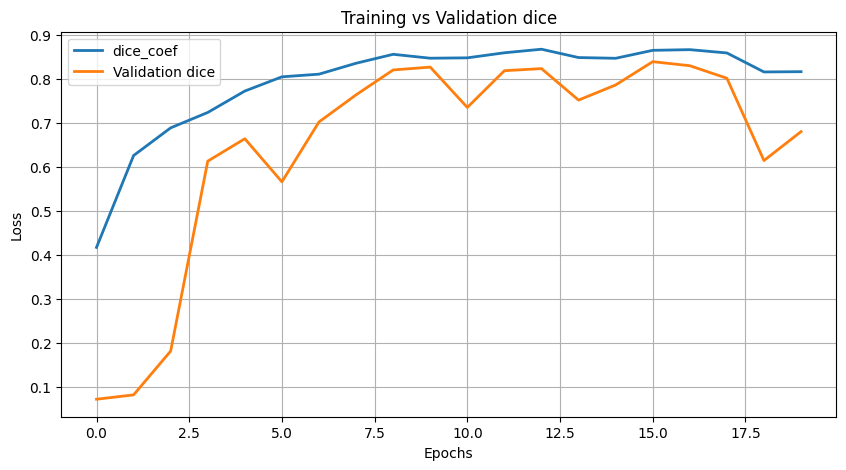

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['dice_coef'], label='dice_coef', linewidth=2)
plt.plot(history.history['val_dice_coef'], label='Validation dice', linewidth=2)
plt.title("Training vs Validation dice")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


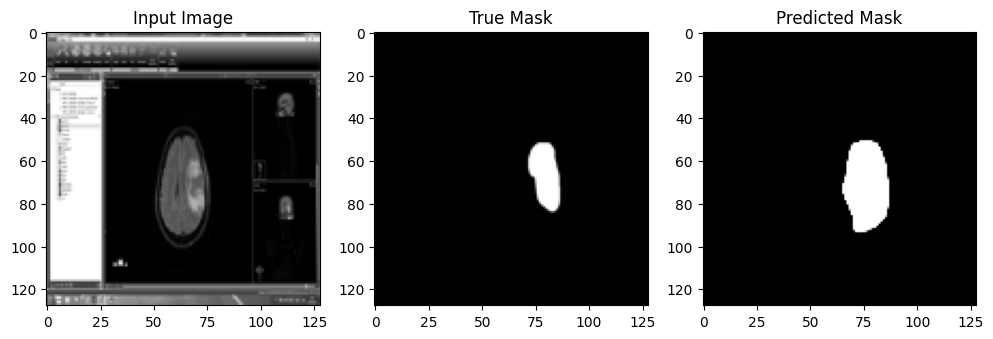

In [21]:
import random
import matplotlib.pyplot as plt
import numpy as np

i = random.randint(0, len(X_val)-1) # Changed X_test to X_val as X_test is not defined
test_img = X_val[i]
test_mask = y_val[i]
pred_mask = model.predict(np.expand_dims(test_img, axis=0))[0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(test_img.squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(test_mask.squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask.squeeze(), cmap='gray')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


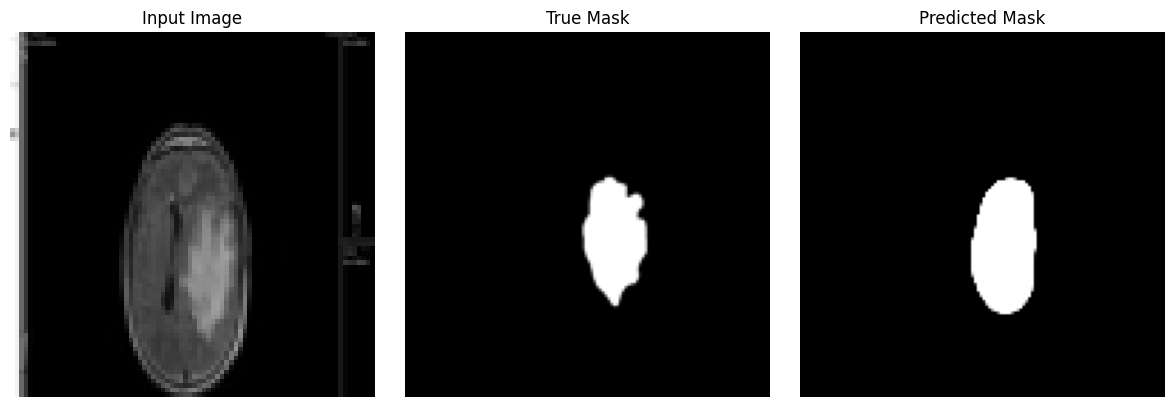

In [42]:
import random
import matplotlib.pyplot as plt
import numpy as np

def zoom_image(img, zoom_size=80):
    # img: shape (128, 128)
    y, x = img.shape
    startx = x // 2 - zoom_size // 2
    starty = y // 2 - zoom_size // 2
    return img[starty:starty + zoom_size, startx:startx + zoom_size]

# Random image
i = random.randint(0, len(X_val) - 1)
test_img = X_val[i]
test_mask = y_val[i]
pred_mask = model.predict(np.expand_dims(test_img, axis=0))[0]

# Zoomed input image (just visual)
zoomed_input = zoom_image(test_img.squeeze(), zoom_size=80)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(zoomed_input, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(test_mask.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [45]:
model.save("/content/drive/MyDrive/seg/kaggle_3m/unet_model_finetuned.h5")